In [1]:
#imports

import numpy as np
import sys 
import os
import subprocess
sys.path.append("./Python")
sys.path.append("./MMSP")
sys.path.append("C:/Cygwin/bin")
import pf_utils as utils
import pf_init as init
import pf_engine as engine
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
np.set_printoptions(threshold=np.inf)

In [6]:
import importlib
importlib.reload(engine)
importlib.reload(utils)
importlib.reload(init)

<module 'pf_init' from './Python\\pf_init.py'>

In [7]:
#initialize the simulation, includes where to save files, the initial step number of zero, and how many steps to simulate per run

data_path = '3c3p_1d_2'
tdb_path_2c = 'Ni-Cu_Ideal.tdb'
tdb_path_3c = 'Ni-Cu-Al_Ideal.tdb'
tdb_path_3c3p = 'Ni-Cu-Al_3p.tdb'
tdb_path_3c2p = 'Ni-Cu-Al_2p.tdb'
tdb_path_5c = 'Ni-Cu-Al-Pt-Ag_Ideal.tdb'
tdb_path_snbi = 'Sn-Bi.tdb'
step = 0
steps = 200
nbc = [False, False]
#init.initializePlaneFront(data_path, tdb_path_snbi, 200, 200, c0=[0.002]) #parameters: x-size, y-size, path to save files. Plane-front always uses [True, False] for nbc
#init.initializeSeeds(data_path, tdb_path_5c, 200, 200, nbc[0], nbc[1], 20) #params: x-size, y-size, Neumann Boundary Conditions (X, Y), number of seeds, path to save files
#init.initializeSeed(data_path, tdb_path_5c, 200, 200, nbc[0], nbc[1], c0=[0.01, 0.01, 0.40831, 0.56169]) #params: x-size, y-size, Neumann Boundary Conditions (X, Y), path to save files
#init.initialize1D(data_path, tdb_path_2c, 80, 20, True, 2, 0.40831, 0.40831)
#init.initialize1D(data_path, tdb_path_3c, 80, 20, True, 3, [0.59169, 0.40831], [0.59169, 0.40831])
init.initializeSeed3p(data_path, tdb_path_3c3p, 200, 1, nbc[0], nbc[1], c0=[0.01, 0.40831]) #params: x-size, y-size, Neumann Boundary Conditions (X, Y), path to save files


A simulation has already been created at this path - aborting initialization!
Please choose a different path, or delete the previous simulation


False

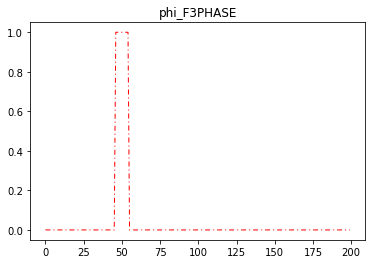

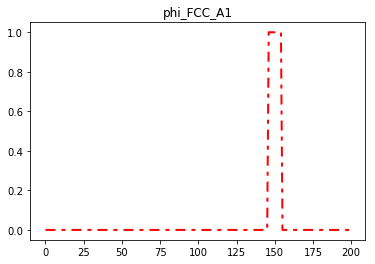

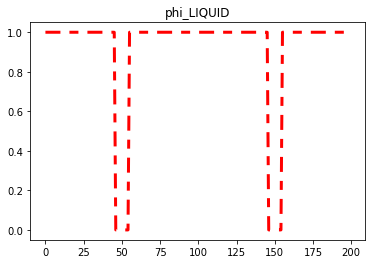

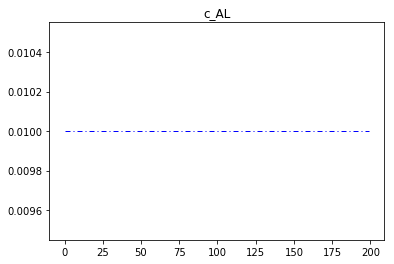

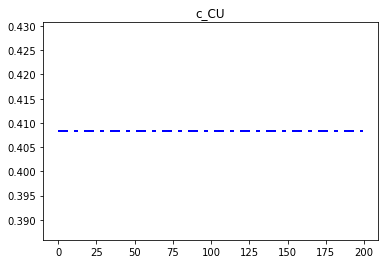

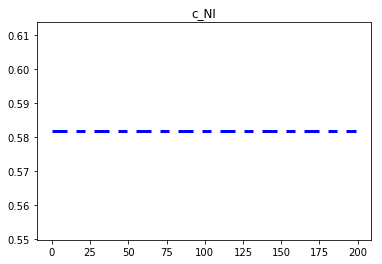

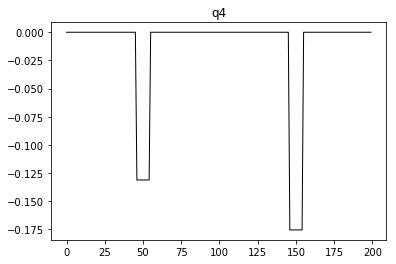

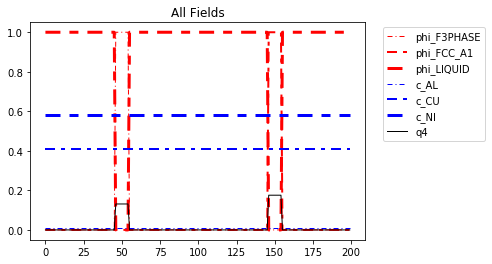

In [8]:
"""
this shows the initial conditions for the simulation
prints phi, q4, and all c fields
"""
step, phi, c, q1, q4 = utils.loadArrays_ncnp(data_path, step)
utils.plot2d(phi, c, q4, nbc, data_path, step)

./Python\pf_utils.py:298: RuntimeWarning: divide by zero encountered in true_divide
  issp2p2 = 1./ssp2p2 #convenience, since division is expensive and its used a lot
./Python\pf_utils.py:301: RuntimeWarning: divide by zero encountered in true_divide
  ivassp2p2 = 1./vassp2p2 #convenience, since division is expensive and its used a lot


0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done


C:\Users\Zhyrek\Anaconda3\envs\m\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...
55.0% done...
60.0% done...
65.0% done...
70.0% done...
75.0% done...
80.0% done...
85.0% done...
90.0% done...
95.0% done...
Done
0.0% done...
5.0% done...
10.0% done...
15.0% done...
20.0% done...
25.0% done...
30.0% done...
35.0% done...
40.0% done...
45.0% done...
50.0% done...

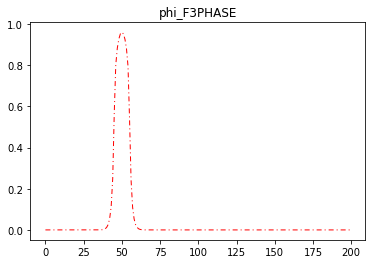

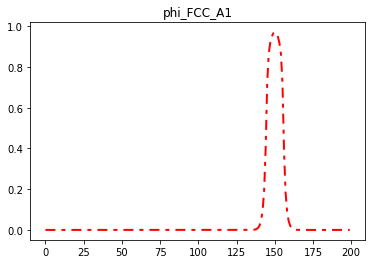

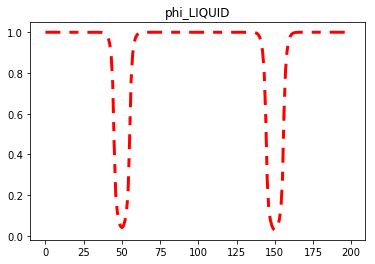

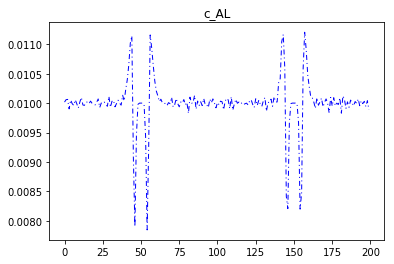

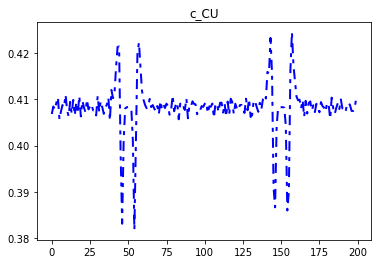

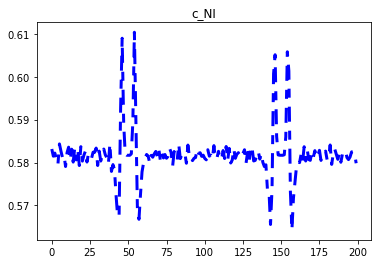

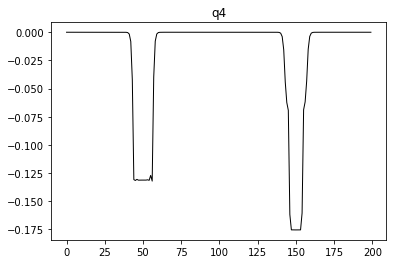

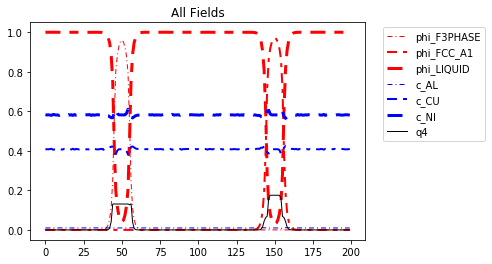

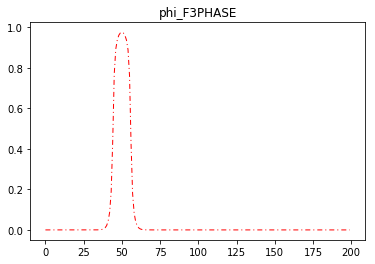

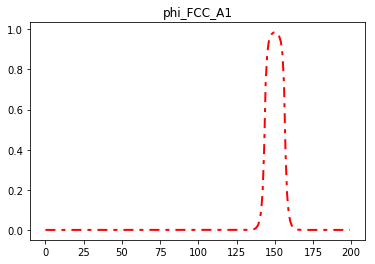

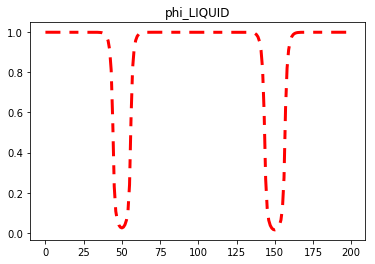

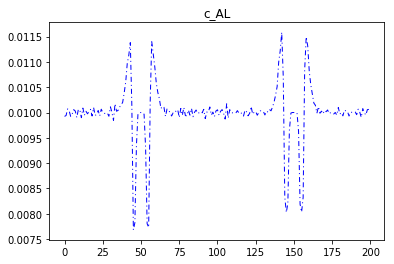

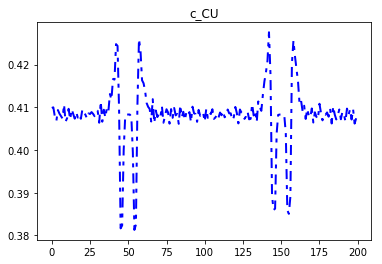

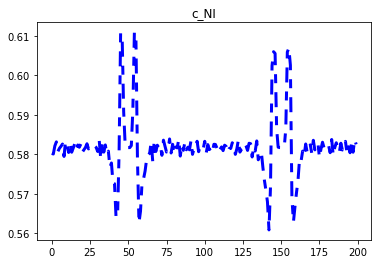

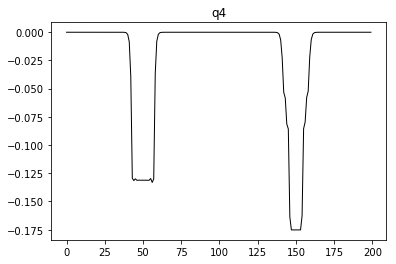

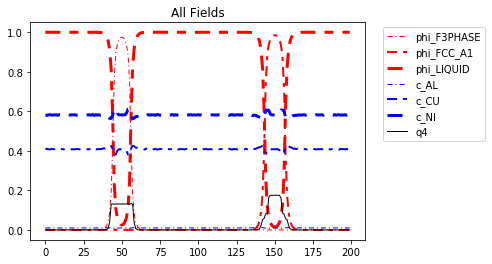

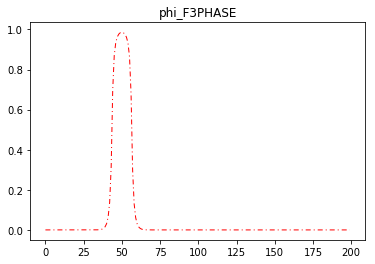

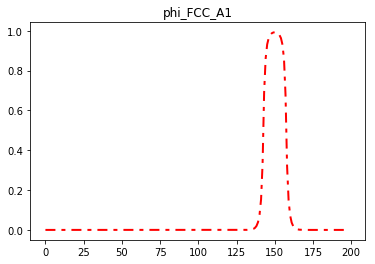

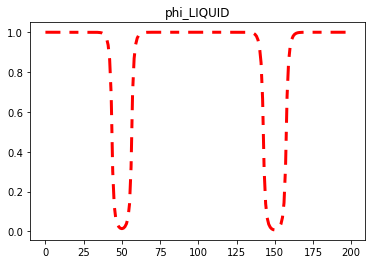

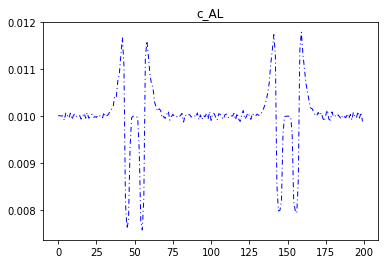

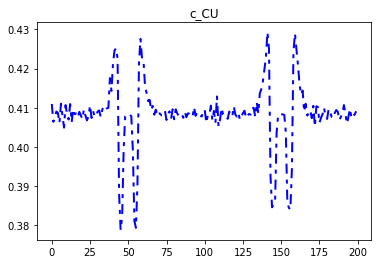

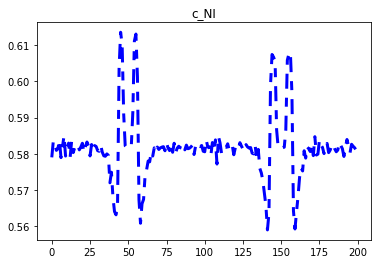

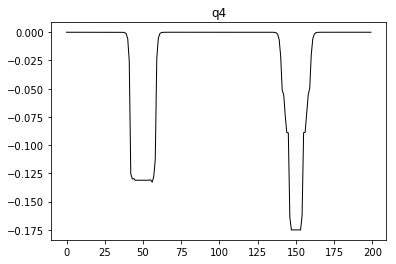

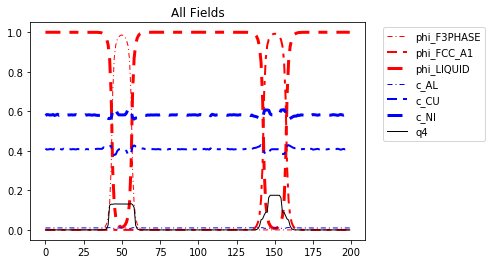

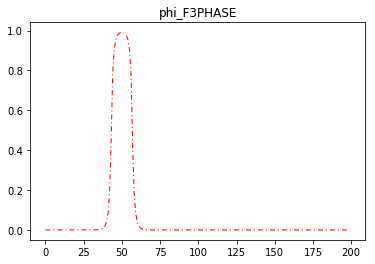

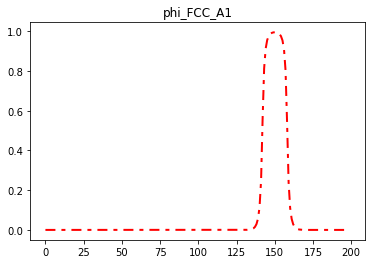

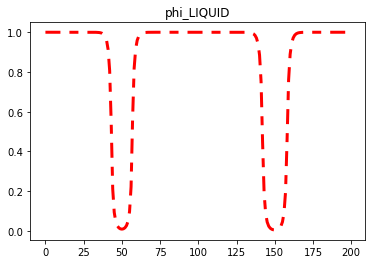

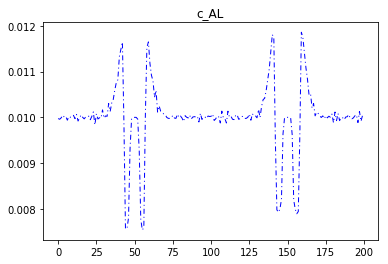

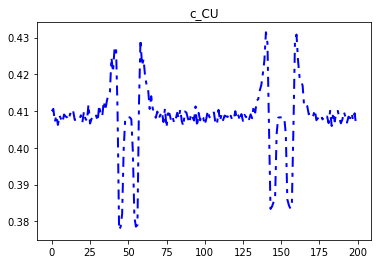

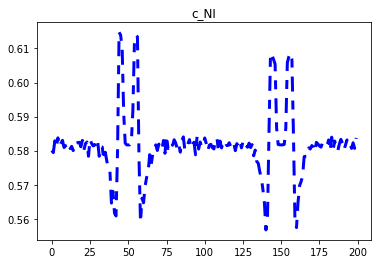

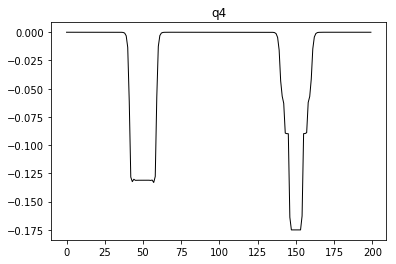

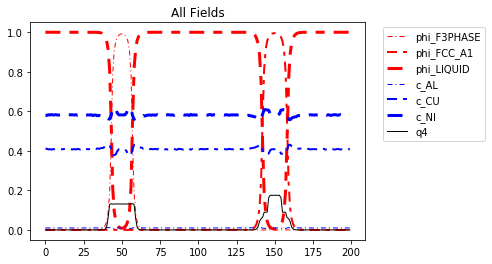

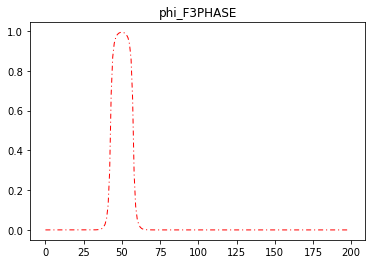

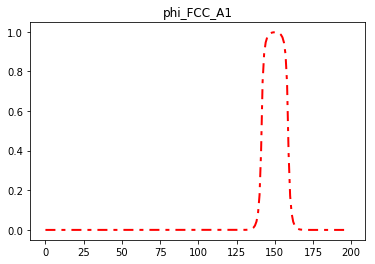

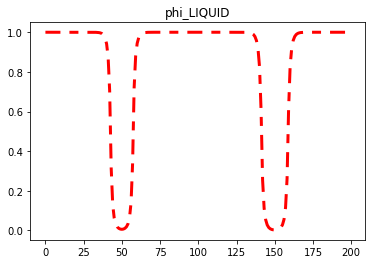

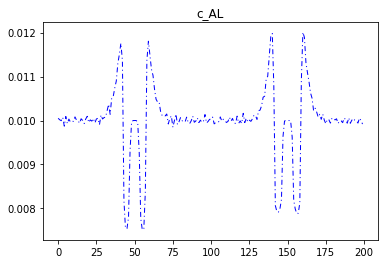

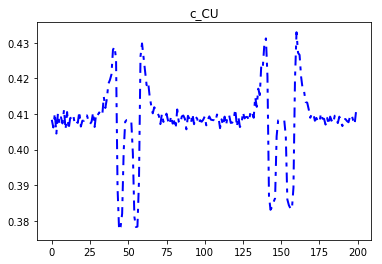

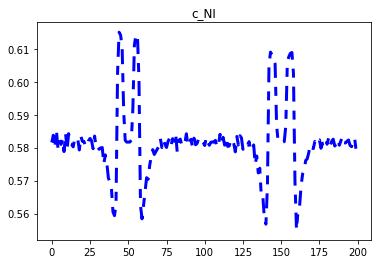

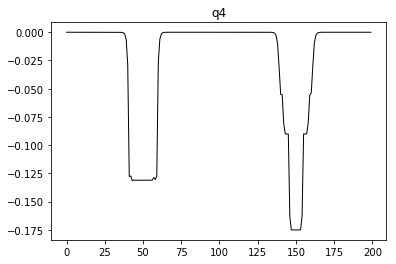

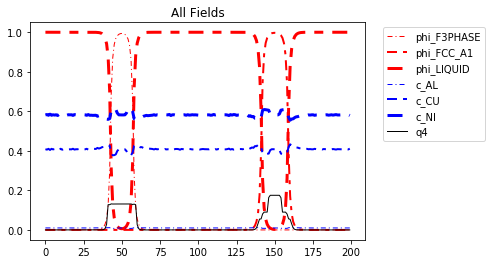

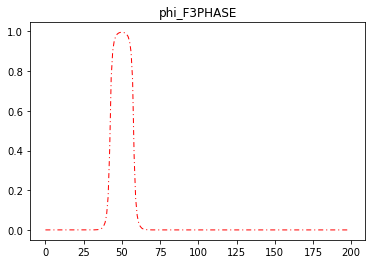

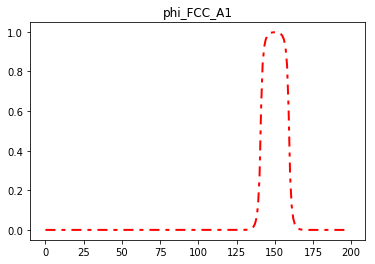

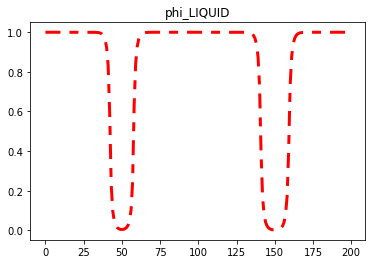

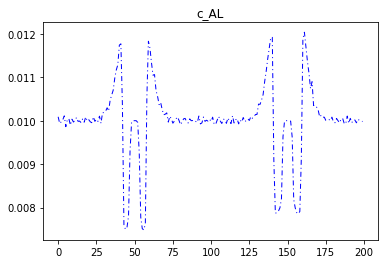

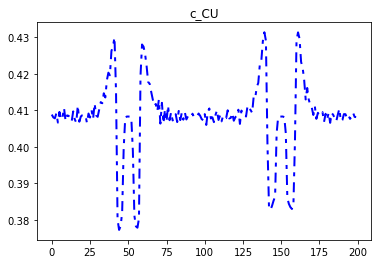

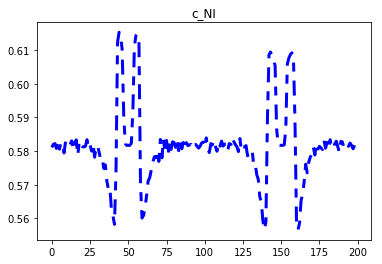

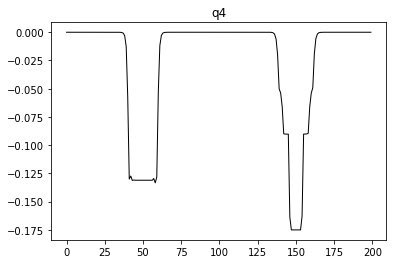

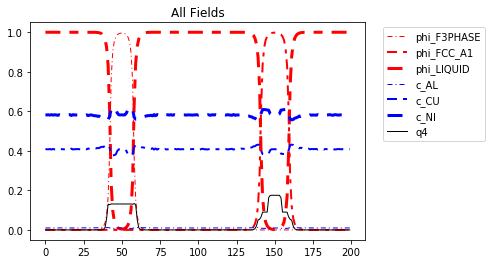

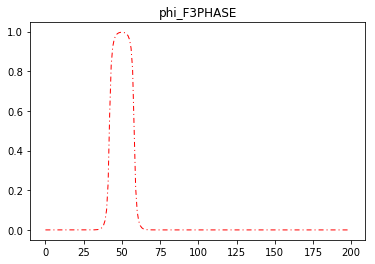

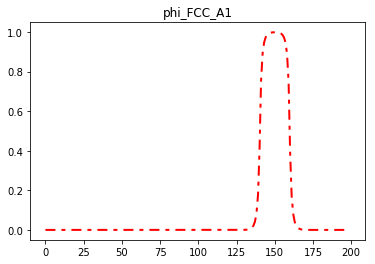

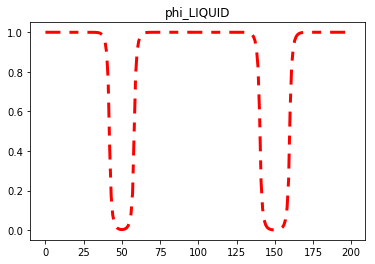

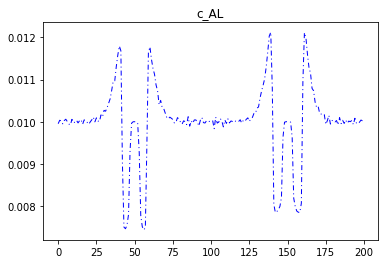

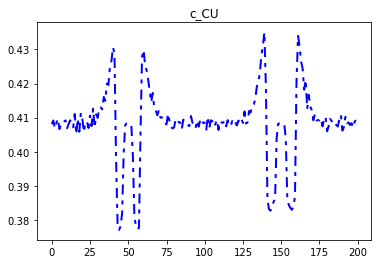

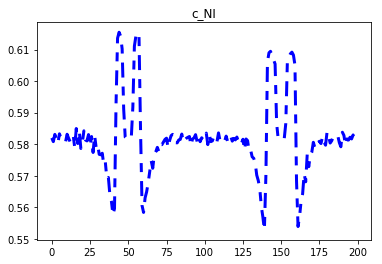

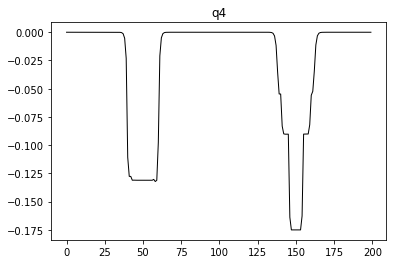

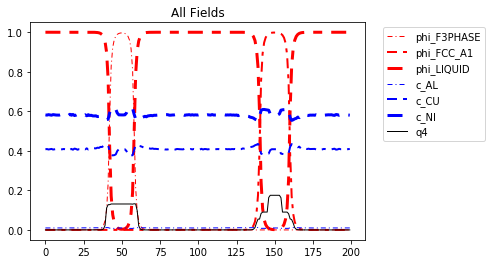

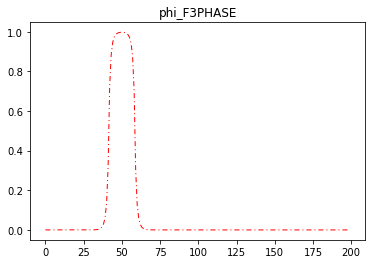

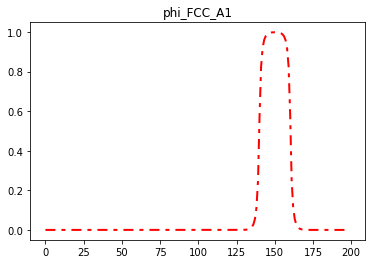

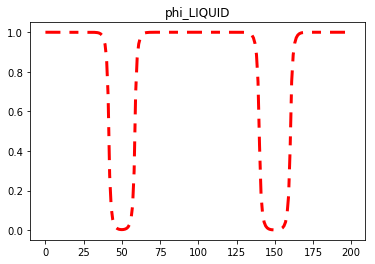

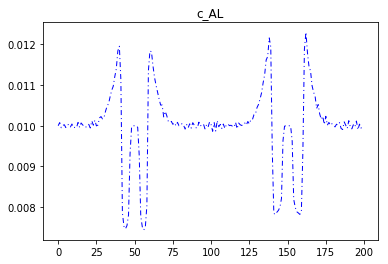

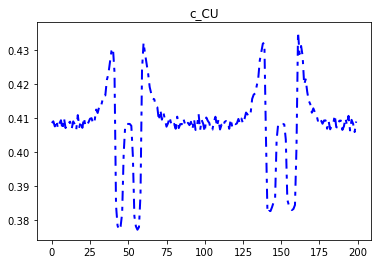

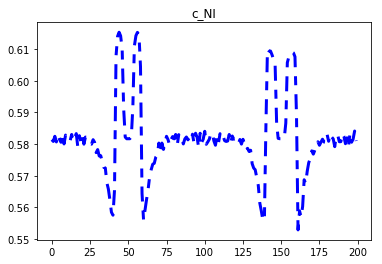

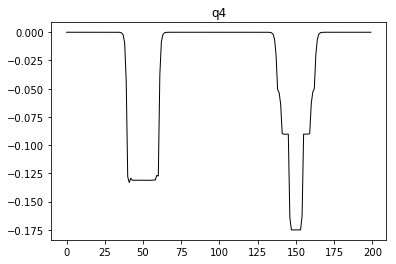

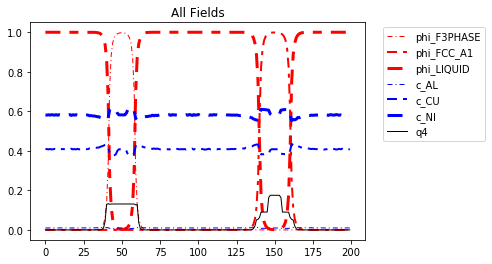

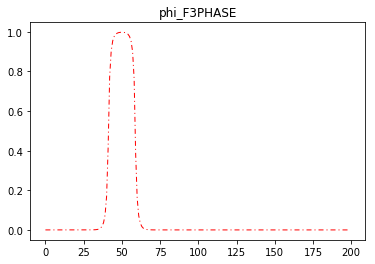

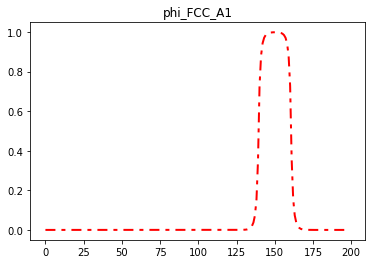

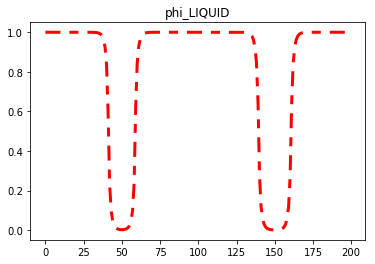

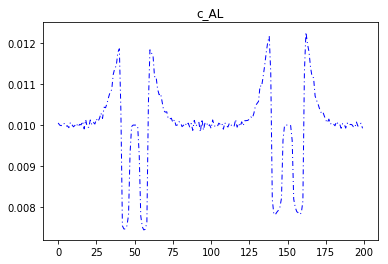

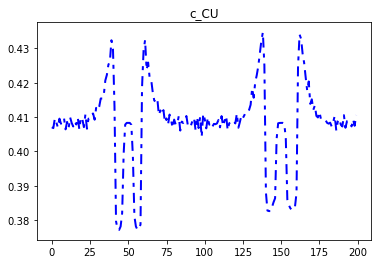

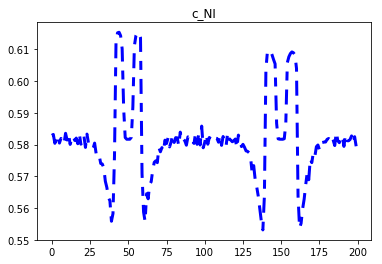

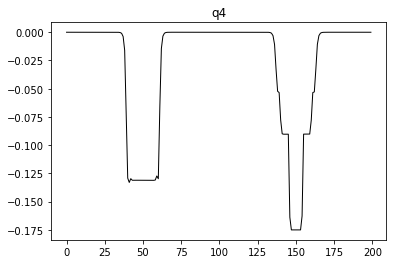

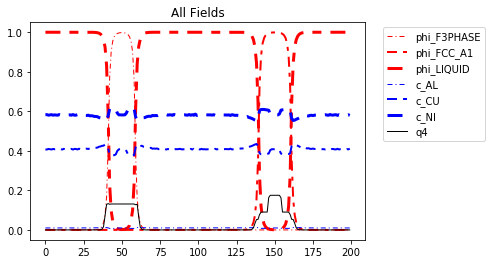

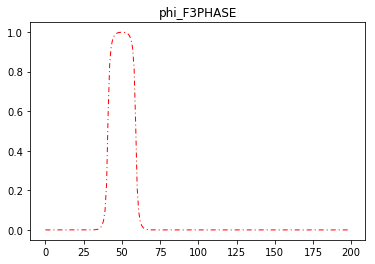

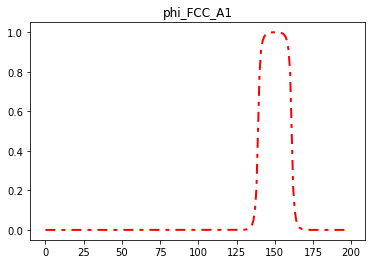

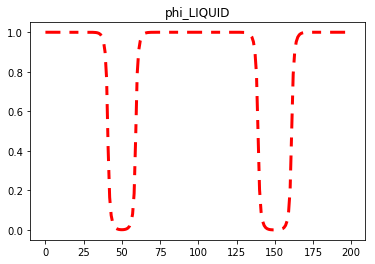

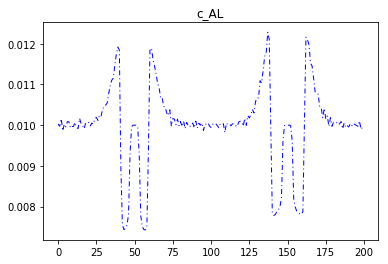

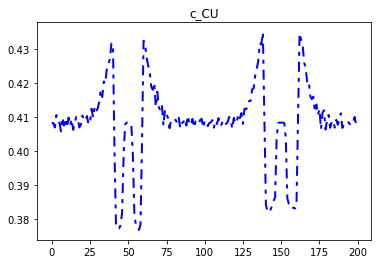

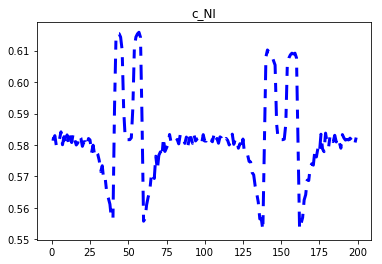

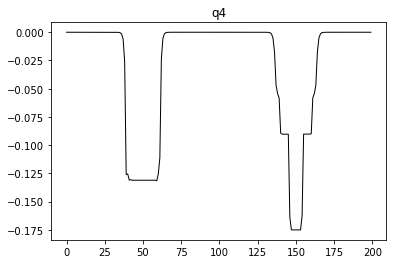

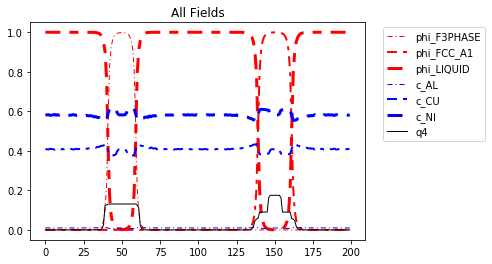

In [9]:
"""
this runs the python engine for the data files selected, then plots the field data as images
"""

for i in range(10): #number of iterations
    engine.simulate_ncnp(data_path, step, steps, 1567., 0.0, 0.0)
    step, phi, c, q1, q4 = utils.loadArrays_ncnp(data_path, step+steps)
    utils.plot2d(phi, c, q4, nbc, data_path, step)
    


In [ ]:
utils.coreSection(q4, nbc).shape[0]

In [ ]:
data_path = 'snbi_08_d'
tdb_path = 'Sn-Bi.tdb'
utils.load_tdb(tdb_path)
for i in range(160):
    step, phi, c, q1, q4 = utils.loadArrays_nc(data_path, 500*i)
    utils.plotImages_nc(phi, c, q4, nbc, data_path, 500*i)



In [ ]:
#this code creates a 3D grid using MMSP
# WARNING - code is proof-of-concept, and may not work on your machine! 
subprocess.Popen(["MMSP/initialize.out", "d:3", "f:MMSP/grid", "o:0.8165,0.3333,0.3333,0.3333", "m:0", "l:25,25,25"])

In [ ]:
#this code runs a 3D grid using MMSP
# WARNING - code is proof-of-concept, and may not work on your machine! 
subprocess.Popen(["MMSP/serial.out", "MMSP/grid", "40", "10"])

# Anisotropic Phase Field Model

This model begins with the following Free Energy functional, similar to Dorr2010 but anisotropic, anisothermal, and allowing for multicomponent.

$$ F = \int_V (\frac{\epsilon_\phi^2\eta T}{2}|\nabla \phi|^2 + f(\phi,c_i) + f_{ori}(\phi, \textbf{q}) + \frac{\epsilon_q^2}{2}|\nabla \textbf{q}|^2 + \lambda (1-\sqrt{\sum q_i^2})) dV$$ 

In order, these terms are:

* The (anisotropic!) interfacial energy in phi
* The bulk free energy
* The orientational energy, representing the energy of lattice mismatch
* The interfacial energy in the orientation (q), artificially added to have smooth orientation transitions
* The Lagrange multiplier term, ensuring the squares of the orientation components sum to 1

We use the following expression to promote cubic symmetry in the PFM:

$$ \eta = 1 - 3\gamma_\epsilon + 4\gamma_\epsilon\frac{\psi_x^4 + \psi_y^4 + \psi_z^4}{|\nabla \phi|^4} $$ 

Here, $\gamma_\epsilon$ represents the magnitude of the anisotropy in the interfacial energy, and all $\psi$ terms are found from rotating the components of $\nabla \phi$ by $\textbf{q}$:

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = (q_1 + q_2\textbf{i} + q_3\textbf{j} + q_4\textbf{k})*(\phi_x\textbf{i} + \phi_y\textbf{j} + \phi_z\textbf{k})*(q_1 - q_2\textbf{i} - q_3\textbf{j} - q_4\textbf{k})$$

It is important to note that, since we are using quaternions, certain multiplications are non-commutative.

$$\textbf{i}\textbf{i} = \textbf{j}\textbf{j} = \textbf{k}\textbf{k} = -1, \textbf{i}\textbf{j} = \textbf{k}, \textbf{j}\textbf{k} = \textbf{i}, \textbf{k}\textbf{i} = \textbf{j}, \textbf{j}\textbf{i} = \textbf{-k}, \textbf{k}\textbf{j} = \textbf{-i}, \textbf{i}\textbf{k} = \textbf{-j}$$

By multiplying out the expression for psi, we may derive equations for them dependent on the various components of $\phi$, and the four quaternion components:

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = (q_1 + q_2\textbf{i} + q_3\textbf{j} + q_4\textbf{k})*(\phi_x\textbf{i} + \phi_y\textbf{j} + \phi_z\textbf{k})*(q_1 - q_2\textbf{i} - q_3\textbf{j} - q_4\textbf{k})$$

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = (q_1\phi_x\textbf{i} + q_1\phi_y\textbf{j} + q_1\phi_z\textbf{k} + q_2\phi_x\textbf{i}\textbf{i} + q_2\phi_y\textbf{i}\textbf{j} + q_2\phi_z\textbf{i}\textbf{k} + q_3\phi_x\textbf{j}\textbf{i} + q_3\phi_y\textbf{j}\textbf{j} + q_3\phi_z\textbf{j}\textbf{k} + q_4\phi_x\textbf{k}\textbf{i} + q_4\phi_y\textbf{k}\textbf{j} + q_4\phi_z\textbf{k}\textbf{k})*(q_1 - q_2\textbf{i} - q_3\textbf{j} - q_4\textbf{k})$$

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = (q_1\phi_x\textbf{i} + q_1\phi_y\textbf{j} + q_1\phi_z\textbf{k} - q_2\phi_x + q_2\phi_y\textbf{k} - q_2\phi_z\textbf{j} - q_3\phi_x\textbf{k} - q_3\phi_y + q_3\phi_z\textbf{i} + q_4\phi_x\textbf{j} - q_4\phi_y\textbf{i} - q_4\phi_z)*(q_1 - q_2\textbf{i} - q_3\textbf{j} - q_4\textbf{k})$$

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = q_1^2\phi_x\textbf{i} + q_1^2\phi_y\textbf{j} + q_1^2\phi_z\textbf{k} - q_1q_2\phi_x + q_1q_2\phi_y\textbf{k} - q_1q_2\phi_z\textbf{j} - q_1q_3\phi_x\textbf{k} - q_1q_3\phi_y + q_1q_3\phi_z\textbf{i} + q_1q_4\phi_x\textbf{j} - q_1q_4\phi_y\textbf{i} - q_1q_4\phi_z - q_1q_2\phi_x\textbf{i}\textbf{i} - q_1q_2\phi_y\textbf{j}\textbf{i} - q_1q_2\phi_z\textbf{k}\textbf{i} + q_2^2\phi_x\textbf{i} - q_2^2\phi_y\textbf{k}\textbf{i} + q_2^2\phi_z\textbf{j}\textbf{i} + q_2q_3\phi_x\textbf{k}\textbf{i} + q_2q_3\phi_y\textbf{i} - q_2q_3\phi_z\textbf{i}\textbf{i} - q_2q_4\phi_x\textbf{j}\textbf{i} + q_2q_4\phi_y\textbf{i}\textbf{i} + q_2q_4\phi_z\textbf{i} - q_1q_3\phi_x\textbf{i}\textbf{j} - q_1q_3\phi_y\textbf{j}\textbf{j} - q_1q_3\phi_z\textbf{k}\textbf{j} + q_2q_3\phi_x\textbf{j} - q_2q_3\phi_y\textbf{k}\textbf{j} + q_2q_3\phi_z\textbf{j}\textbf{j} + q_3^2\phi_x\textbf{k}\textbf{j} + q_3^2\phi_y\textbf{j} - q_3^2\phi_z\textbf{i}\textbf{j} - q_3q_4\phi_x\textbf{j}\textbf{j} + q_3q_4\phi_y\textbf{i}\textbf{j} + q_3q_4\phi_z\textbf{j} - q_1q_4\phi_x\textbf{i}\textbf{k} - q_1q_4\phi_y\textbf{j}\textbf{k} - q_1q_4\phi_z\textbf{k}\textbf{k} + q_2q_4\phi_x\textbf{k} - q_2q_4\phi_y\textbf{k}\textbf{k} + q_2q_4\phi_z\textbf{j}\textbf{k} + q_3q_4\phi_x\textbf{k}\textbf{k} + q_3q_4\phi_y\textbf{k} - q_3q_4\phi_z\textbf{i}\textbf{k} - q_4^2\phi_x\textbf{j}\textbf{k} + q_4^2\phi_y\textbf{i}\textbf{k} + q_4^2\phi_z\textbf{k}$$

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = q_1^2\phi_x\textbf{i} + q_1^2\phi_y\textbf{j} + q_1^2\phi_z\textbf{k} - q_1q_2\phi_x + q_1q_2\phi_y\textbf{k} - q_1q_2\phi_z\textbf{j} - q_1q_3\phi_x\textbf{k} - q_1q_3\phi_y + q_1q_3\phi_z\textbf{i} + q_1q_4\phi_x\textbf{j} - q_1q_4\phi_y\textbf{i} - q_1q_4\phi_z + q_1q_2\phi_x + q_1q_2\phi_y\textbf{k} - q_1q_2\phi_z\textbf{j} + q_2^2\phi_x\textbf{i} - q_2^2\phi_y\textbf{j} - q_2^2\phi_z\textbf{k} + q_2q_3\phi_x\textbf{j} + q_2q_3\phi_y\textbf{i} + q_2q_3\phi_z + q_2q_4\phi_x\textbf{k} - q_2q_4\phi_y + q_2q_4\phi_z\textbf{i} - q_1q_3\phi_x\textbf{k} + q_1q_3\phi_y + q_1q_3\phi_z\textbf{i} + q_2q_3\phi_x\textbf{j} + q_2q_3\phi_y\textbf{i} - q_2q_3\phi_z - q_3^2\phi_x\textbf{i} + q_3^2\phi_y\textbf{j} - q_3^2\phi_z\textbf{k} + q_3q_4\phi_x + q_3q_4\phi_y\textbf{k} + q_3q_4\phi_z\textbf{j} + q_1q_4\phi_x\textbf{j} - q_1q_4\phi_y\textbf{i} + q_1q_4\phi_z + q_2q_4\phi_x\textbf{k} + q_2q_4\phi_y + q_2q_4\phi_z\textbf{i} - q_3q_4\phi_x + q_3q_4\phi_y\textbf{k} + q_3q_4\phi_z\textbf{j} - q_4^2\phi_x\textbf{i} - q_4^2\phi_y\textbf{j} + q_4^2\phi_z\textbf{k}$$

In this expression, every term that does not have a imaginary component (i,j,k) will have a matching, opposite sign term. Therefore, all these terms will cancel out. Then, we group terms based on which component they have:

$$\psi_x\textbf{i} + \psi_y\textbf{j} + \psi_z\textbf{k} = (q_1^2\phi_x + q_1q_3\phi_z - q_1q_4\phi_y + q_2^2\phi_x + q_2q_3\phi_y + q_2q_4\phi_z + q_1q_3\phi_z + q_2q_3\phi_y - q_3^2\phi_x - q_1q_4\phi_y + q_2q_4\phi_z - q_4^2\phi_x)\textbf{i} + (q_1^2\phi_y - q_1q_2\phi_z + q_1q_4\phi_x - q_1q_2\phi_z - q_2^2\phi_y + q_2q_3\phi_x + q_2q_3\phi_x + q_3^2\phi_y + q_3q_4\phi_z + q_1q_4\phi_x + q_3q_4\phi_z - q_4^2\phi_y)\textbf{j} + (q_1^2\phi_z + q_1q_2\phi_y - q_1q_3\phi_x + q_1q_2\phi_y - q_2^2\phi_z + q_2q_4\phi_x - q_1q_3\phi_x - q_3^2\phi_z + q_3q_4\phi_y + q_2q_4\phi_x + q_3q_4\phi_y + q_4^2\phi_z)\textbf{k}$$

From this equation, we can get the final expression for each of the three psi components:

$$\psi_x = (q_1^2 + q_2^2 - q_3^2 - q_4^2)\phi_x + (2q_2q_3 - 2q_1q_4)\phi_y + (2q_2q_4 + 2q_1q_3)\phi_z$$

$$\psi_y = (2q_2q_3 + 2q_1q_4)\phi_x + (q_1^2 - q_2^2 + q_3^2 - q_4^2)\phi_y + (2q_3q_4 - 2q_1q_2)\phi_z$$

$$\psi_z = (2q_2q_4 - 2q_1q_3)\phi_x + (2q_3q_4 + 2q_1q_2)\phi_y + (q_1^2 - q_2^2 - q_3^2 + q_4^2)\phi_z$$

In 2D, the only meaningful rotation is within the xy plane, so we require that $q_2 = q_3 = 0$ for the 2D model. Additionally, $\phi_z = 0$. As a consequence, the expressions for $\psi$ simplify in the following manner:

$$\psi_x = (q_1^2 - q_4^2)\phi_x - 2q_1q_4\phi_y$$

$$\psi_y = 2q_1q_4\phi_x + (q_1^2 - q_4^2)\phi_y$$

$$\psi_z = 0$$

Returning to the function equation, the bulk free energy, and the orientational mismatch energy are represented by the following equations:

$$ f(\phi, c) = (1-c)(W^Ag(\phi)T + (1-\frac{T}{T_m^A})(e_s^A(T_m^A) - C^AT_m^A + m(\phi)L^A) - C^ATln\frac{T}{T_m^A} + \frac{RT}{v_m}ln(1-c)) + c(W^Bg(\phi)T + (1-\frac{T}{T_m^B})(e_s^B(T_m^B) - C^BT_m^B + m(\phi)L^B) - C^BTln\frac{T}{T_m^B} + \frac{RT}{v_m}ln(c))$$

$$ f_{ori}(\phi, \textbf{q}) = 2HTp(\phi)|\nabla \textbf{q}|$$

These expressions are dependent on several material properties, derived properties, and physical parameters, as well as the three interpolating functions, $g(\phi)$, $m(\phi)$, and $p(\phi)$. Below, descriptions and/or equations are given where appropriate:

* $g(\phi) = \phi^2(1-\phi)^2$
* $m(\phi) = 1 - \phi^3(10-15\phi+6\phi^2)$
* $p(\phi) = \phi^2$
* $T$: Temperature (in Kelvin)
* $T_m^A$, $T_m^B$: Melting temperature of pure material A and B
* $e_s^A(T_X)$, $e_s^B(T_X)$: Internal energies of pure A and B, at some temperature $T_X$
* $C^A$, $C^B$: Heat capacities of pure A and B
* $L^A$, $L^B$: Latent heat of pure A and B
* $R$: Gas constant
* $v_m$: molar volume
* $W^A$: Well height of A, $= \frac{3\sigma^A}{\sqrt{2}T_m^A\delta^A}$
* $W^B$: Well height of B, $= \frac{3\sigma^B}{\sqrt{2}T_m^B\delta^B}$
* $\sigma^A$, $\sigma^B$: Surface energy of pure A and B
* $\delta^A$, $\delta^B$: Interfacial thickness of A and B

We also define the interfacial energy coefficient, $\epsilon_\phi$, using these terms as well:

* $\epsilon_\phi^2 = \frac{6\sqrt{2}\sigma^A\delta^A}{T_m^A} = \frac{6\sqrt{2}\sigma^B\delta^B}{T_m^B}$

In this simulation, A is pure Nickel, and B is pure Copper, with the simulation being treated as an ideal solution. Many of these expressions are taken from Warren1995.



# Multiorder Multicomponent Model

The functional expression for this model is:

$$ F = \int_\Omega (f_{int} + f_{bulk} + f_{ori}) d\Omega $$

Where the individual terms are:

$$ f_{int} = \frac{\epsilon^2(\boldsymbol{\phi}, \mathbf{q})T}{2}\sum_i |\nabla \phi_i|^2 $$

$$ f_{bulk} = \sum_i (h(\phi_i)G_i(\mathbf{c}, T)) + w(\boldsymbol{\phi})g(\boldsymbol{\phi})T $$

$$ f_{ori} = T|\nabla \mathbf{q}|\sum_i (p(\phi_i)H_i) $$

In these expressions, several other functions are shown:

$G_i$ is the Gibbs Free Energy (in J/cm3) of phase i, for a particular composition and temperature, computed using pycalphad.

$$ \epsilon^2 =  \frac{\sum_i \sum_{j < i}\epsilon_{ij}^2\eta_{ij}(\mathbf{q})\phi_i^2\phi_j^2}{\sum_i \sum_{j < i}\phi_i^2\phi_j^2} $$

$\eta_{ij}$ is some function which captures the anisotropy of the i-j interface. For now, we consider all interfaces to be of the form:

$$ \eta_{ij} = 1-3\gamma_{ij}+4\gamma_{ij}\frac{\psi_x^4 + \psi_y^4 + \psi_z^4}{|\nabla\phi_i-\nabla\phi_j|^4} $$

Where $\nabla\psi$ is the vector $\nabla\phi_i-\nabla\phi_j$ rotated by the quaternion $\mathbf{q}$:

$$\psi_x = (q_1^2 + q_2^2 - q_3^2 - q_4^2)(\phi_{x,i}-\phi_{x,j}) + (2q_2q_3 - 2q_1q_4)(\phi_{y,i}-\phi_{y,j}) + (2q_2q_4 + 2q_1q_3)(\phi_{z,i}-\phi_{z,j})$$

$$\psi_y = (2q_2q_3 + 2q_1q_4)(\phi_{x,i}-\phi_{x,j}) + (q_1^2 - q_2^2 + q_3^2 - q_4^2)(\phi_{y,i}-\phi_{y,j}) + (2q_3q_4 - 2q_1q_2)(\phi_{z,i}-\phi_{z,j})$$

$$\psi_z = (2q_2q_4 - 2q_1q_3)(\phi_{x,i}-\phi_{x,j}) + (2q_3q_4 + 2q_1q_2)(\phi_{y,i}-\phi_{y,j}) + (q_1^2 - q_2^2 - q_3^2 + q_4^2)(\phi_{z,i}-\phi_{z,j})$$

$$ w = \frac{\sum_i \sum_{j < i}w_{ij}\phi_i^2\phi_j^2}{\sum_i \sum_{j < i}\phi_i^2\phi_j^2} $$

(Note: for simplicity, we assume that the well function is NOT dependent on composition here!)

Additionally, from Boettinger2002, we can find the values of $\epsilon^2_{ij}$ and $w_{ij}$ from the surface energy and our choice of interfacial thickness (a free parameter strictly larger than a single PF cell's width):

$$ \epsilon^2_{ij} = 6\sigma_{ij}\delta, w_{ij} = 3\frac{\sigma_{ij}}{\delta}$$

$$ g = \frac{1}{12} + \sum_i(\frac{\phi_i^4}{4}-\frac{\phi_i^3}{3}) + \frac{1}{2}\sum_i \sum_{j < i} \phi_i^2\phi_j^2 $$

$$ h(\phi_i) = \phi_i^3(10-15\phi_i+6\phi_i^2) $$

$$ p(\phi_i) = \phi_i^2 $$

Rate equations are of the form:

$$ \frac{d\phi_i}{dt} = -\sum_{j \neq i} \kappa_{ij} (\frac{\delta F}{\delta \phi_i} - \frac{\delta F}{\delta \phi_j}) $$

$$ \frac{dc_i}{dt} = \nabla \cdot (\frac{Dc_i(1-c_i)}{RT}\nabla \frac{\delta F}{\delta c_i} - \sum_{j \neq i} \frac{Dc_ic_j}{RT}\nabla \frac{\delta F}{\delta c_j}) $$

$$ \frac{dq_i}{dt} = -M_q(2q_i\lambda + \frac{\delta F}{\delta q_i}) $$

This last one uses Lagrange multipliers, and the term lambda may be solved for using the expression:

$$ \sum_i q_i\frac{dq_i}{dt} = 0$$

# Rate equations

### Order (phi)

$$ \frac{d\phi_i}{dt} = -\sum_{j \neq i} \kappa_{ij} (\frac{\partial (f_{int} + f_{bulk} + f_{ori})}{\partial \phi_i} - \frac{\partial (f_{int} + f_{bulk} + f_{ori})}{\partial \phi_j} - \nabla \cdot \frac{\partial (f_{int})}{\partial \nabla\phi_i} + \nabla \cdot \frac{\partial (f_{int})}{\partial \nabla\phi_i}) $$

$$ \frac{d\phi_i}{dt} = -\sum_{j \neq i} \kappa_{ij} (\frac{\partial (f_{int} + f_{bulk} + f_{ori})}{\partial \phi_i} - \frac{\partial (f_{int} + f_{bulk} + f_{ori})}{\partial \phi_j} - \frac{d}{dx} \frac{\partial (f_{int})}{\partial \phi_{x,i}} - \frac{d}{dy} \frac{\partial (f_{int})}{\partial \phi_{y,i}} - \frac{d}{dz} \frac{\partial (f_{int})}{\partial \phi_{z,i}} + \frac{d}{dx} \frac{\partial (f_{int})}{\partial \phi_{x,j}} + \frac{d}{dy} \frac{\partial (f_{int})}{\partial \phi_{y,j}} + \frac{d}{dz} \frac{\partial (f_{int})}{\partial \phi_{z,j}}) $$

If we let $\kappa_{ii}$ = $-\sum_{j\neq i}\kappa_{ij}$, the expression simplifies somewhat:

$$ \frac{d\phi_i}{dt} = \sum_{j} \kappa_{ij} (\frac{\partial (f_{int} + f_{bulk} + f_{ori})}{\partial \phi_j} - \frac{d}{dx} \frac{\partial (f_{int})}{\partial \phi_{x,j}} - \frac{d}{dy} \frac{\partial (f_{int})}{\partial \phi_{y,j}} - \frac{d}{dz} \frac{\partial (f_{int})}{\partial \phi_{z,j}}) $$

Because $|\nabla\phi_i|^2 = \phi_x^2 + \phi_y^2 + \phi_z^2$:

$$ \frac{d\phi_i}{dt} = \sum_{j} \kappa_{ij} (0.5T\frac{\partial \epsilon^2}{\partial \phi_j}\sum_k(|\nabla\phi_k|^2) + h(\phi_j)G_j + \frac{\partial w}{\partial \phi_j}gT + \frac{\partial g}{\partial \phi_j}wT + H_jT\frac{\partial p(\phi_j)}{\partial \phi_j}|\nabla\mathbf{q}| - \frac{d}{dx} (0.5T\frac{\partial \epsilon^2}{\partial \phi_{x,j}}\sum_k(|\nabla\phi_k|^2) + T\epsilon^2\phi_{x,j}) - \frac{d}{dy} (0.5T\frac{\partial \epsilon^2}{\partial \phi_{y,j}}\sum_k(|\nabla\phi_k|^2) + T\epsilon^2\phi_{y,j}) - \frac{d}{dz} (0.5T\frac{\partial \epsilon^2}{\partial \phi_{z,j}}\sum_k(|\nabla\phi_k|^2) + T\epsilon^2\phi_{z,j})) $$

## Substitutions

$$ \frac{\partial \epsilon^2}{\partial \phi_j} = \frac{(\sum_{k\neq j} 2\epsilon_{jk}^2\eta_{jk}\phi_j\phi_k^2)(\sum_k\sum_{l \neq k}\phi_k^2\phi_l^2) - (\sum_k\sum_{l \neq k} \epsilon_{kl}^2\eta_{kl}\phi_k^2\phi_l^2)(\sum_{k\neq j}2\phi_j\phi_k^2)}{(\sum_k\sum_{l \neq k}\phi_k^2\phi_l^2)^2} $$

Due to the symmetry of eta, we can use the following expressions:

$$ \frac{\partial \epsilon^2}{\partial \phi_{x,j}} = \frac{1}{\sum_k\sum_{l \neq k}\phi_k^2\phi_l^2} \sum_{k\neq j}4\gamma_{jk}\epsilon_{jk}^2\phi_j^2\phi_k^2(\frac{4\psi_x^3(q_1^2 + q_2^2 - q_3^2 - q_4^2) + 4\psi_y^3(2q_2q_3 + 2q_1q_4) + 4\psi_z^3(2q_2q_4 - 2q_1q_3)}{|\nabla\phi_j-\nabla\phi_k|^4} - \frac{4|\nabla\phi_j-\nabla\phi_k|^2(\phi_{x,j}-\phi_{x,k})(\psi_x^4 + \psi_y^4 + \psi_z^4)}{|\nabla\phi_i-\nabla\phi_j|^8}) $$

$$ \frac{\partial \epsilon^2}{\partial \phi_{y,j}} = \frac{1}{\sum_k\sum_{l \neq k}\phi_k^2\phi_l^2} \sum_{k\neq j}4\gamma_{jk}\epsilon_{jk}^2\phi_j^2\phi_k^2(\frac{4\psi_x^3(2q_2q_3 - 2q_1q_4) + 4\psi_y^3(q_1^2 - q_2^2 + q_3^2 - q_4^2) + 4\psi_z^3(2q_3q_4 + 2q_1q_2)}{|\nabla\phi_j-\nabla\phi_k|^4} - \frac{4|\nabla\phi_j-\nabla\phi_k|^2(\phi_{y,j}-\phi_{y,k})(\psi_x^4 + \psi_y^4 + \psi_z^4)}{|\nabla\phi_i-\nabla\phi_j|^8}) $$

$$ \frac{\partial \epsilon^2}{\partial \phi_{z,j}} = \frac{1}{\sum_k\sum_{l \neq k}\phi_k^2\phi_l^2} \sum_{k\neq j}4\gamma_{jk}\epsilon_{jk}^2\phi_j^2\phi_k^2(\frac{4\psi_x^3(2q_2q_4 + 2q_1q_3) + 4\psi_y^3(2q_3q_4 - 2q_1q_2) + 4\psi_z^3(q_1^2 - q_2^2 - q_3^2 + q_4^2)}{|\nabla\phi_j-\nabla\phi_k|^4} - \frac{4|\nabla\phi_j-\nabla\phi_k|^2(\phi_{z,j}-\phi_{z,k})(\psi_x^4 + \psi_y^4 + \psi_z^4)}{|\nabla\phi_i-\nabla\phi_j|^8}) $$

$$ \frac{\partial w}{\partial \phi_j} = \frac{(\sum_{k\neq j} 2w_{jk}\phi_j\phi_k^2)(\sum_k\sum_{l \neq k}\phi_k^2\phi_l^2) - (\sum_k\sum_{l \neq k} w_{kl}\phi_k^2\phi_l^2)(\sum_{k\neq j}2\phi_j\phi_k^2)}{(\sum_k\sum_{l \neq k}\phi_k^2\phi_l^2)^2} $$

$$ \frac{\partial g}{\partial \phi_j} = \phi_j^3 - \phi_j^2 + \sum_{k \neq j}\phi_j\phi_k^2 $$

### Composition (c)

$$ \frac{dc_i}{dt} = \nabla \cdot (\frac{Dc_i(1-c_i)}{RT}\nabla \frac{\partial (f_{bulk})}{\partial c_i} - \sum_{j \neq i} \frac{Dc_ic_j}{RT}\nabla \frac{\partial (f_{bulk})}{\partial c_j}) $$

$$ \frac{dc_i}{dt} = \nabla \cdot (\frac{Dc_i(1-c_i)}{RT}\nabla \sum_k (h(\phi_k)\frac{\partial G_k(\mathbf{c}, T)}{\partial c_i}) - \sum_{j \neq i} \frac{Dc_ic_j}{RT}\nabla \sum_k (h(\phi_k)\frac{\partial G_k(\mathbf{c}, T)}{\partial c_j})) $$

Terms of the form $\frac{\partial G_k(\mathbf{c}, T)}{\partial c_i}$ may be directly retrieved from pycalphad

### Orientation (q)

$$ \frac{dq_i}{dt} = -M_q(2q_i\lambda + \frac{\partial (f_{int})}{\partial q_i} - \nabla \cdot \frac{\partial (f_{ori})}{\partial \nabla q_i}) $$

$$ \frac{dq_i}{dt} = -M_q(2q_i\lambda + \frac{T}{2}\frac{\partial \epsilon^2}{\partial q_i}\sum_j |\nabla \phi_j|^2 - \nabla \cdot T\sum_j (p(\phi_j)H_j)\frac{\partial \sqrt{\sum_j |\nabla q_j|^2}}{\partial \nabla q_i}) $$

$$ \frac{dq_i}{dt} = -M_q(2q_i\lambda + \frac{T}{2}\frac{\partial \epsilon^2}{\partial q_i}\sum_j |\nabla \phi_j|^2 - \frac{\partial}{\partial x} T\sum_j (p(\phi_j)H_j)\frac{\partial \sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}}{\partial q_{x,i}} - \frac{\partial}{\partial y} T\sum_j (p(\phi_j)H_j)\frac{\partial \sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}}{\partial q_{y,i}} - \frac{\partial}{\partial z} T\sum_j (p(\phi_j)H_j)\frac{\partial \sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}}{\partial q_{z,i}}) $$

$$ \frac{dq_i}{dt} = -M_q(2q_i\lambda + \frac{T}{2}\frac{\partial \epsilon^2}{\partial q_i}\sum_j |\nabla \phi_j|^2 - \frac{\partial}{\partial x} \frac{ q_{x,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}} - \frac{\partial}{\partial y} \frac{ q_{y,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}} - \frac{\partial}{\partial z} \frac{ q_{z,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}}) $$

### Substitutions

$$ \frac{\partial \epsilon^2}{\partial q_i} = \frac{\sum_j \sum_{k < j}(\epsilon_{jk}^2\frac{\partial \eta_{jk}}{\partial q_i}\phi_j^2\phi_k^2)}{\sum_j \sum_{k < j}(\phi_j^2\phi_k^2)} $$

$$ \frac{\partial \eta_{jk}}{\partial q_i} = (\psi_x^3\frac{\partial\psi_x}{\partial q_i} + \psi_y^3\frac{\partial\psi_y}{\partial q_i} + \psi_z^3\frac{\partial\psi_z}{\partial q_i})\frac{16\gamma_{jk}}{|\nabla\phi_j-\nabla\phi_k|^4} $$

Due to lack of symmetry, use expressions for psi separately for these

Solving for $\lambda$:

$$ \sum_i q_i(2q_i\lambda + \sum_j \sum_{k < j}(\epsilon_{jk}^2\frac{\partial \eta_{jk}}{\partial q_i}(\mathbf{q})\phi_j^2\phi_k^2)\frac{T}{2\sum_j \sum_{k < j}(\phi_j^2\phi_k^2)}\sum_j |\nabla \phi_j|^2 - \frac{\partial}{\partial x} \frac{ q_{x,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}} - \frac{\partial}{\partial y} \frac{ q_{y,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}} - \frac{\partial}{\partial z} \frac{ q_{z,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}}) = 0$$

$$ 2\lambda\sum_i (q_i^2) + \sum_i q_i(\sum_j \sum_{k < j}(\epsilon_{jk}^2\frac{\partial \eta_{jk}}{\partial q_i}(\mathbf{q})\phi_j^2\phi_k^2)\frac{T}{2\sum_j \sum_{k < j}(\phi_j^2\phi_k^2)}\sum_j |\nabla \phi_j|^2 - \frac{\partial}{\partial x} \frac{ q_{x,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}} - \frac{\partial}{\partial y} \frac{ q_{y,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}} - \frac{\partial}{\partial z} \frac{ q_{z,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}}) = 0$$

Because $\sum_i (q_i^2) = 1$:

$$ 2\lambda + \sum_i q_i(\sum_j \sum_{k < j}(\epsilon_{jk}^2\frac{\partial \eta_{jk}}{\partial q_i}(\mathbf{q})\phi_j^2\phi_k^2)\frac{T}{2\sum_j \sum_{k < j}(\phi_j^2\phi_k^2)}\sum_j |\nabla \phi_j|^2 - \frac{\partial}{\partial x} \frac{ q_{x,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}} - \frac{\partial}{\partial y} \frac{ q_{y,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}} - \frac{\partial}{\partial z} \frac{ q_{z,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}}) = 0$$

$$ \lambda = -0.5\sum_i q_i(\sum_j \sum_{k < j}(\epsilon_{jk}^2\frac{\partial \eta_{jk}}{\partial q_i}(\mathbf{q})\phi_j^2\phi_k^2)\frac{T}{2\sum_j \sum_{k < j}(\phi_j^2\phi_k^2)}\sum_j |\nabla \phi_j|^2 - \frac{\partial}{\partial x} \frac{ q_{x,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}} - \frac{\partial}{\partial y} \frac{ q_{y,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}} - \frac{\partial}{\partial z} \frac{ q_{z,i}T\sum_j (p(\phi_j)H_j)}{\sqrt{\sum_j (q_{x,j}^2+q_{y,j}^2+q_{z,j}^2)}})$$

$$ \frac{d\phi}{dx} = \lim_{\Delta x->0}\frac{\phi(x+\Delta x)-\phi(x)}{\Delta x} $$
\\

$$ \frac{d\phi}{dx}\Big|_n \approx \frac{\phi_{(n+1)}-\phi_{(n)}}{\Delta x} $$
\\

$$ \frac{d\phi}{dx}\Big|_n \approx 0.5(\frac{\phi_{(n+1)}-\phi_{(n)}}{\Delta x} + \frac{\phi_{(n)}-\phi_{(n-1)}}{\Delta x}) = \frac{\phi_{(n+1)}-\phi_{(n-1)}}{2\Delta x} $$
\\

$$ \frac{d^2\phi}{dx^2}\Big|_n \approx \frac{\frac{d\phi}{dx}\Big|_n-\frac{d\phi}{dx}\Big|_{n-1}}{\Delta x} = \frac{\phi_{(n+1)}-\phi_{(n)}-(\phi_{(n)}-\phi_{(n-1)})}{\Delta x^2} = \frac{\phi_{(n+1)}+\phi_{(n-1)}-2\phi_{(n)}}{\Delta x^2} $$

$$ \phi_x $$

$$ \phi_y $$

$$ x'\textbf{i}+y'\textbf{j}+z'\textbf{k} = (a+b\textbf{i}+c\textbf{j}+d\textbf{k})(x\textbf{i}+y\textbf{j}+z\textbf{k})(a-b\textbf{i}-c\textbf{j}-d\textbf{k}) $$

$$ \frac{\partial \psi}{\partial x}\textbf{i}+\frac{\partial \psi}{\partial y}\textbf{j}+\frac{\partial \psi}{\partial z}\textbf{k} = (a+b\textbf{i}+c\textbf{j}+d\textbf{k})(\frac{\partial \phi}{\partial x}\textbf{i}+\frac{\partial \phi}{\partial y}\textbf{j}+\frac{\partial \phi}{\partial z}\textbf{k})(a-b\textbf{i}-c\textbf{j}-d\textbf{k}) $$